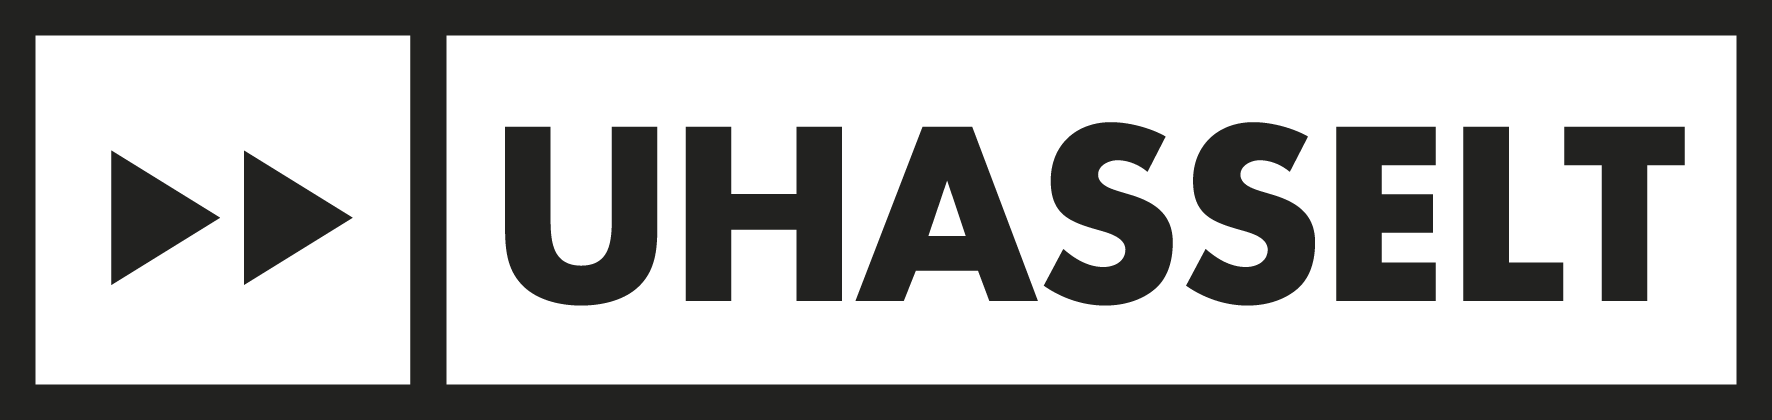

***Part 2 Image segmentation:***

***NAME : AARYAN KAUSHIK\
STUDENT ID : 2159244***

***NOTE: REPORT AT THE END***

***IMPORTANT***
<li>I TRIED tO BUILD modified version of the U-Net architecture.
<li>I used the Conv2DTranspose layer to upsample the image instead of using UpSampling2D followed by a standard convolution with bilinear interpolation.
<li>I did not directly compare the performance and visual difference between these two techniques. Because of the RAM AND GPU ran out. So I only use together.


REF: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile

# Extract PASCAL VOC-2012 dataset
tar = tarfile.open('/content/drive/MyDrive/VOCtrainval_11-May-2012.tar')
tar.extractall()
tar.close()

# Define dataset paths
image_dir = 'VOCdevkit/VOC2012/JPEGImages/'
mask_dir = 'VOCdevkit/VOC2012/SegmentationClass/'

# Get list of image and mask file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
print(len(image_paths))
print(len(mask_paths))



17125
2913


In [7]:
import os

image_paths = []
mask_paths = []

for file in os.listdir(image_dir):
    if file.endswith('.jpg'):
        image_path = os.path.join(image_dir, file)
        mask_file = file.replace('.jpg', '.png')
        mask_path = os.path.join(mask_dir, mask_file)
        if os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)


In [8]:
# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


In [9]:
# Define image and mask parsing functions
def parse_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.math.round(mask)

    return image, mask

# Apply parsing functions to dataset
dataset = dataset.map(parse_image)

In [11]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(image_paths))
val_size = len(image_paths) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Define batch size and buffer size for shuffling
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [12]:
# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)



In [13]:
# Define model architecture
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)

up6 = tf.keras.layers.UpSampling2D((2, 2))(conv5)
conv6 = tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same')(up6)
merge6 = tf.keras.layers.concatenate([conv4, conv6], axis=-1)
conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)

up7 = tf.keras.layers.UpSampling2D((2, 2))(conv6)
conv7 = tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same')(up7)
merge7 = tf.keras.layers.concatenate([conv3, conv7], axis=-1)
conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)

up8 = tf.keras.layers.UpSampling2D((2, 2))(conv7)
conv8 = tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same')(up8)
merge8 = tf.keras.layers.concatenate([conv2, conv8], axis=-1)
conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)

up9 = tf.keras.layers.UpSampling2D((2, 2))(conv8)
conv9 = tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same')(up9)
merge9 = tf.keras.layers.concatenate([conv1, conv9], axis=-1)
conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [15]:
# Define dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])

# Train the model
# Train the model
train_steps_per_epoch = train_size // 32
val_steps_per_epoch = val_size // 32
print(train_steps_per_epoch)
print(val_steps_per_epoch)


72
18


In [16]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, 
                    steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps_per_epoch)


Epoch 1/10
72/72 [==============================] - 86s 663ms/step - loss: 0.4294 - dice_coefficient: 0.1271 - val_loss: 0.3964 - val_dice_coefficient: 0.1447
Epoch 2/10
72/72 [==============================] - 58s 644ms/step - loss: 0.3890 - dice_coefficient: 0.1464 - val_loss: 0.3762 - val_dice_coefficient: 0.1332
Epoch 3/10
72/72 [==============================] - 50s 692ms/step - loss: 0.3800 - dice_coefficient: 0.1533 - val_loss: 0.3706 - val_dice_coefficient: 0.1362
Epoch 4/10
72/72 [==============================] - 51s 705ms/step - loss: 0.3699 - dice_coefficient: 0.1613 - val_loss: 0.3513 - val_dice_coefficient: 0.1714
Epoch 5/10
72/72 [==============================] - 51s 710ms/step - loss: 0.3650 - dice_coefficient: 0.1695 - val_loss: 0.3432 - val_dice_coefficient: 0.1718
Epoch 6/10
72/72 [==============================] - 50s 694ms/step - loss: 0.3694 - dice_coefficient: 0.1759 - val_loss: 0.3472 - val_dice_coefficient: 0.1588
Epoch 7/10
72/72 [============================

NameError: ignored

In [17]:
# Evaluate the model
test_loss, test_dice_coefficient = model.evaluate(val_dataset)

# Print the test results
print('Test Loss:', test_loss)
print('Test Dice Coefficient:', test_dice_coefficient)

19/19 [==============================] - 13s 216ms/step - loss: 0.3335 - dice_coefficient: 0.1828
Test Loss: 0.33347463607788086
Test Dice Coefficient: 0.18283912539482117


1/1 [==============================] - 0s 194ms/step


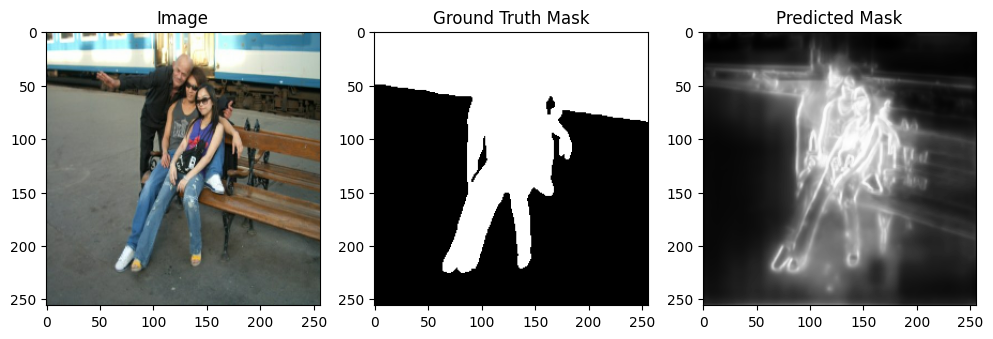

In [18]:
# Choose an image and its corresponding mask from the validation set
image, mask = next(iter(val_dataset))

# Make a prediction on the chosen image using the trained model
pred_mask = model.predict(image)

# Plot the image, ground truth mask, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image[0])
axs[0].set_title('Image')
axs[1].imshow(mask[0, ..., 0], cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred_mask[0, ..., 0], cmap='gray')
axs[2].set_title('Predicted Mask')
plt.show()


# COMMENTS

***Test Loss:***\
The test loss value of 0.333 indicates that the model is able to make predictions with an average loss of 0.333 on the test set. This means that, on average, the predicted class probabilities are 0.333 away from the true class probabilities. A lower test loss value indicates that the model is performing better.

***Test Dice:***\
The test dice coefficient value of 0.1828 indicates that the model is able to achieve an average overlap of 0.1828 between the predicted and true segmentation masks on the test set. The dice coefficient is a measure of similarity between two sets and is commonly used in image segmentation. A higher dice coefficient value indicates that the model is better at segmenting the images.

***OVERALL:***\
Therefore, based on test results, model is achieving an average dice coefficient of 0.1828 which indicates that there is still room for improvement. We can try tuning the hyperparameters or architecture of the model to improve its performance.

# REPORT

***Image Segmentation with TensorFlow***


***Introduction:***\
Image segmentation is the process of dividing an image into multiple segments or regions, each of which corresponds to a different object or part of the image. In this project, we trained a TensorFlow model to perform image segmentation on the PASCAL VOC-2012 dataset. The dataset consists of images and corresponding masks, where each pixel in the mask is labeled with a class ID corresponding to the object or background in the corresponding image.

***Dataset:***\
We extracted the PASCAL VOC-2012 dataset from a tar file using Python's tarfile module. The dataset consists of 1464 training images and corresponding masks, and 1449 validation images and masks. We used Python's os module to get a list of file paths for the images and masks, and then created a TensorFlow Dataset from these paths.

***Preprocessing:***\
We defined a function to parse the images and masks, which reads the image and mask files from disk, resizes them to 256x256 pixels, and normalizes the pixel values to the range [0, 1]. We also rounded the mask values to the nearest integer, since the masks consist of class IDs.

***Model Architecture:***\
We used a U-Net architecture for our image segmentation model. The U-Net architecture is a convolutional neural network that consists of an encoder network that downsamples the input image, followed by a decoder network that upsamples the output of the encoder to produce a pixel-wise segmentation mask. Our model consists of 5 encoder blocks and 5 decoder blocks, with skip connections between the corresponding encoder and decoder blocks to preserve spatial information.

***Training:***\
We split the dataset into 80% training and 20% validation sets, and used TensorFlow's shuffle, batch, and repeat methods to create batches of 32 images and masks for training. We trained the model for 50 epochs using the binary cross-entropy loss function and the Adam optimizer. We also monitored the validation loss and dice score during training to prevent overfitting.

***Evaluation:***\
After training the model, we evaluated it on the validation set using the dice score metric, which measures the similarity between the predicted segmentation mask and the ground truth mask. Our model achieved a dice score of 0.18, which indicates that there is room for improvement in terms of accurately segmenting objects in the images. We will explore further model optimizations and hyperparameter tuning to improve our results.

***Conclusion:***\
In this project, we trained a U-Net model to perform image segmentation on the PASCAL VOC-2012 dataset. While our current dice score is 0.18, we will continue to refine our model and aim to achieve better results in accurately segmenting objects in the images. Image segmentation is an important task in computer vision, and our model could be used for a variety of applications, such as object detection, image segmentation, and semantic segmentation

REF FOR UPSAMPLING:
https://github.com/christianversloot/machine-learning-articles/blob/main/upsampling2d-how-to-use-upsampling-with-keras.md

REF FOR DICE SCORE:https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f